# 残差网络（ResNet）和ResNeXt
:label:`sec_resnet`

当我们设计越来越深的网络时，理解增加层数如何提高网络的复杂性和表达能力变得至关重要。
更重要的是能够设计出这样的网络：增加层数使网络严格更具表达力，而不仅仅是不同。
为了取得一些进展，我们需要一点数学知识。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 函数类

考虑$\mathcal{F}$，这是特定网络架构（连同学习率和其他超参数设置）可以达到的函数类。
也就是说，对于所有$f \in \mathcal{F}$，都存在一些通过在适当的数据集上训练可以获得的参数集（例如权重和偏置）。
假设$f^*$是我们真正想要找到的“真实”函数。
如果它在$\mathcal{F}$中，我们就处于有利位置，但通常我们不会这么幸运。
相反，我们将尝试在$\mathcal{F}$内找到最佳选择$f^*_\mathcal{F}$。
例如，
给定一个具有特征$\mathbf{X}$
和标签$\mathbf{y}$的数据集，
我们可能尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ subject to } f \in \mathcal{F}.$$

我们知道正则化 :cite:`tikhonov1977solutions,morozov2012methods` 可以控制$\mathcal{F}$的复杂度
并实现一致性，因此较大的训练数据量
通常会导致更好的$f^*_\mathcal{F}$。
如果我们设计了一个不同且更强大的架构$\mathcal{F}'$，我们理应得到更好的结果。换句话说，我们期望$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更好”。然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，这甚至不能保证会发生。实际上，$f^*_{\mathcal{F}'}$可能会更差。
如:numref:`fig_functionclasses`所示，
对于非嵌套的函数类，更大的函数类并不总是能更接近“真实”函数$f^*$。例如，
在:numref:`fig_functionclasses`左侧，
尽管$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，$\mathcal{F}_6$却远离了，并且没有保证进一步增加复杂性能够减少与$f^*$的距离。
对于嵌套函数类
其中$\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$
在:numref:`fig_functionclasses`右侧，
我们可以避免上述非嵌套函数类的问题。


![对于非嵌套的函数类，更大的（由面积表示）函数类并不能保证我们会更接近“真实”函数（$\mathit{f}^*$）。这种情况在嵌套函数类中不会发生。](../img/functionclasses.svg)
:label:`fig_functionclasses`

因此，
只有当更大的函数类包含较小的函数类时，我们才能保证增加它们严格地增加了网络的表现力。
对于深度神经网络，
如果我们能够
将新添加的层训练成恒等函数$f(\mathbf{x}) = \mathbf{x}$，新的模型将与原始模型一样有效。由于新模型可能找到更好的解决方案来拟合训练数据集，新增加的层可能更容易减少训练误差。

这就是:citet:`He.Zhang.Ren.ea.2016`在研究非常深的计算机视觉模型时所考虑的问题。
他们提出的*残差网络*(*ResNet*)的核心思想是每个附加层应该
更容易
包含恒等函数作为其元素之一。
这些考虑相当深刻，但它们导致了一个令人惊讶简单的
解决方案，即*残差块*。
借助它，ResNet赢得了2015年的ImageNet大规模视觉识别挑战赛。这一设计对如何
构建深度神经网络产生了深远影响。例如，循环网络中加入了残差块 :cite:`prakash2016neural,kim2017residual`。同样，Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` 使用它们有效地堆叠许多层网络。它也被用于图神经网络 :cite:`Kipf.Welling.2016` 并且作为一个基本概念，在计算机视觉中被广泛使用 :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`。
注意，残差网络之前有高速公路网络 :cite:`srivastava2015highway` 分享了一些动机，尽管没有围绕恒等函数的优雅参数化。


## (**残差块**)
:label:`subsec_residual-blks`

让我们聚焦于神经网络的一个局部部分，如:numref:`fig_residual_block`所示。设输入为$\mathbf{x}$。
我们假设$f(\mathbf{x})$，我们希望通过学习获得的目标映射，将被用作顶部激活函数的输入。
在左边，
虚线框内的部分
必须直接学习$f(\mathbf{x})$。
在右边，
虚线框内的部分
需要学习*残差映射*$g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$，
这也是残差块得名的原因。
如果恒等映射$f(\mathbf{x}) = \mathbf{x}$是目标映射，
残差映射就等于$g(\mathbf{x}) = 0$，因此更容易学习：
我们只需要将虚线框内
上层权重层（例如全连接层和卷积层）
的权重和偏置
推向零。
右图展示了ResNet的*残差块*，
其中实线携带层输入
$\mathbf{x}$到加法运算符
被称为*残差连接*（或*捷径连接*）。
有了残差块，输入可以通过跨层的残差连接更快地前向传播。
实际上，
残差块
可以被视为
多分支Inception块的一个特例：
它有两个分支
其中一个就是恒等映射。

![在一个常规块（左）中，虚线框内的部分必须直接学习映射$\mathit{f}(\mathbf{x})$。在一个残差块（右）中，虚线框内的部分需要学习残差映射$\mathit{g}(\mathbf{x}) = \mathit{f}(\mathbf{x}) - \mathbf{x}$，使恒等映射$\mathit{f}(\mathbf{x}) = \mathbf{x}$更容易学习。](../img/residual-block.svg)
:label:`fig_residual_block`


ResNet采用了VGG的全$3\times 3$卷积层设计。残差块有两个输出通道数相同的$3\times 3$卷积层。每个卷积层后跟一个批量归一化层和ReLU激活函数。然后，我们跳过这两个卷积操作，并在最终ReLU激活函数之前直接加上输入。
这种设计要求两个卷积层的输出必须与输入形状相同，以便可以相加。如果我们想改变通道数量，我们需要引入一个额外的$1\times 1$卷积层来将输入转换为所需的形状以进行相加操作。让我们来看看下面的代码。

In [2]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

这段代码生成了两种类型的网络：一种是在 `use_1x1conv=False` 时，在应用ReLU非线性之前将输入加到输出上；另一种是通过 $1 \times 1$ 卷积调整通道数和分辨率后再进行相加。:numref:`fig_resnet_block` 说明了这一点。

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](../img/resnet-block.svg)
:label:`fig_resnet_block`

现在让我们看看[**输入和输出形状相同的情况**]，这种情况下不需要 $1 \times 1$ 卷积。

In [3]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

我们还可以选择[**将输出的高度和宽度减半，同时增加输出通道的数量**]。在这种情况下，我们通过`use_1x1conv=True`使用$1 \times 1$卷积。这在每个ResNet块的开始处非常有用，可以通过`strides=2`来减少空间维度。

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet 模型**]

ResNet 的前两层与我们之前描述的 GoogLeNet 相同：一个输出通道为 64、步幅为 2 的 $7\times 7$ 卷积层，后面跟着一个步幅为 2 的 $3\times 3$ 最大池化层。不同之处在于 ResNet 在每个卷积层后都添加了批量归一化层。

In [5]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet 使用了由 Inception 块组成的四个模块。
然而，ResNet 使用了由残差块组成的四个模块，每个模块都使用了多个具有相同输出通道数的残差块。
第一个模块中的通道数与输入通道数相同。由于已经使用了步幅为2的最大池化层，因此不需要减少高度和宽度。在后续每个模块的第一个残差块中，通道数是前一个模块的两倍，而高度和宽度则减半。

In [6]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

然后，我们将所有模块添加到ResNet中。这里，每个模块使用两个残差块。最后，就像GoogLeNet一样，我们添加一个全局平均池化层，接着是全连接层输出。

In [7]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

每个模块中有四个卷积层（不包括$1\times 1$卷积层）。加上最初的$7\times 7$卷积层和最后的全连接层，总共有18层。因此，这个模型通常被称为ResNet-18。
通过在模块中配置不同数量的通道和残差块，我们可以创建不同的ResNet模型，例如更深的152层ResNet-152。尽管ResNet的主要架构与GoogLeNet相似，但ResNet的结构更简单，更容易修改。所有这些因素导致了ResNet的快速和广泛使用。:numref:`fig_resnet18`描绘了完整的ResNet-18。

![The ResNet-18 architecture.](../img/resnet18-90.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察输入形状在ResNet的不同模块中是如何变化的**]。与所有之前的架构一样，分辨率降低而通道数增加，直到全局平均池化层汇总所有特征为止。

In [8]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [9]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## [**训练**]

我们在Fashion-MNIST数据集上训练ResNet，就像之前一样。ResNet是一个非常强大且灵活的架构。捕捉训练和验证损失的图表显示了两条曲线之间存在显著差距，其中训练损失明显较低。对于这种灵活性的网络，更多的训练数据将有助于缩小这一差距并提高准确性。

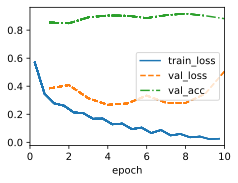

In [10]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## ResNeXt
:label:`subsec_resnext`

在设计ResNet时遇到的一个挑战是在给定块内非线性和维度之间的权衡。也就是说，我们可以通过增加层数或增加卷积的宽度来增加更多的非线性。另一种策略是增加可以在块之间携带信息的通道数量。不幸的是，后者伴随着一个二次惩罚，因为摄入$c_\textrm{i}$个通道并输出$c_\textrm{o}$个通道的计算成本与$\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$成正比（参见:numref:`sec_channels`中的讨论）。

我们可以从:numref:`fig_inception`中的Inception块获得一些灵感，该块的信息通过不同的组流动。将多独立组的思想应用于:numref:`fig_resnet_block`中的ResNet块导致了ResNeXt的设计 :cite:`Xie.Girshick.Dollar.ea.2017`。
不同于Inception中多种变换的组合，
ResNeXt在所有分支中采用相同的变换，
从而最小化了每个分支手动调优的需求。

![The ResNeXt block. The use of grouped convolution with $\mathit{g}$ groups is $\mathit{g}$ times faster than a dense convolution. It is a bottleneck residual block when the number of intermediate channels $\mathit{b}$ is less than $\mathit{c}$.](../img/resnext-block.svg)
:label:`fig_resnext_block`

将从$c_\textrm{i}$到$c_\textrm{o}$个通道的卷积分解为$g$组大小为$c_\textrm{i}/g$生成$g$个大小为$c_\textrm{o}/g$的输出的过程被称为分组卷积。计算成本（按比例）从$\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$减少到$\mathcal{O}(g \cdot (c_\textrm{i}/g) \cdot (c_\textrm{o}/g)) = \mathcal{O}(c_\textrm{i} \cdot c_\textrm{o} / g)$，即快了$g$倍。更好的是，生成输出所需的参数数量也从$c_\textrm{i} \times c_\textrm{o}$矩阵减少到了$g$个较小的$(c_\textrm{i}/g) \times (c_\textrm{o}/g)$矩阵，同样减少了$g$倍。接下来我们假设$c_\textrm{i}$和$c_\textrm{o}$都能被$g$整除。

这种设计中唯一的挑战是$g$组之间没有信息交换。:numref:`fig_resnext_block`中的ResNeXt块通过两种方式修正了这一点：具有$3 \times 3$核的分组卷积夹在两个$1 \times 1$卷积之间。第二个$1 \times 1$卷积同时起到改变通道数的作用。这样做的好处是我们只为$1 \times 1$核支付$\mathcal{O}(c \cdot b)$的成本，并且可以仅用$\mathcal{O}(b^2 / g)$的成本来处理$3 \times 3$核。类似于:numref:`subsec_residual-blks`中的残差块实现，残差连接被（因此被泛化为）$1 \times 1$卷积取代。

:numref:`fig_resnext_block`右图提供了一个更加简洁的结果网络块总结。它还将在:numref:`sec_cnn-design`中现代通用CNN的设计中扮演重要角色。请注意，分组卷积的想法可以追溯到AlexNet的实现:cite:`Krizhevsky.Sutskever.Hinton.2012`。当将网络分布在两个内存有限的GPU上时，实现中将每个GPU视为其自己的通道而没有任何不良影响。

下面的`ResNeXtBlock`类实现接受参数`groups`（$g$），以及`bot_channels`（$b$）中间（瓶颈）通道。最后，当我们需要减少表示的高度和宽度时，我们通过设置`use_1x1conv=True, strides=2`添加步幅为2。

In [11]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

其使用方式与之前讨论的`ResNetBlock`完全类似。例如，当使用（`use_1x1conv=False, strides=1`）时，输入和输出的形状相同。或者，设置`use_1x1conv=True, strides=2`会将输出的高度和宽度减半。

In [12]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

## 摘要与讨论

嵌套函数类是理想的，因为它们在增加容量时允许我们获得严格上*更强大*而不是仅仅*不同*的函数类。实现这一点的一种方法是让额外的层简单地将输入传递到输出。残差连接允许这样做。因此，这将归纳偏差从简单的函数形式$f(\mathbf{x}) = 0$改变为简单的函数看起来像$f(\mathbf{x}) = \mathbf{x}$。

残差映射可以更容易地学习恒等函数，例如将权重层中的参数推向零。通过拥有残差块，我们可以训练有效的*深层*神经网络。输入可以通过跨层的残差连接更快地前向传播。因此，我们可以训练更深的网络。例如，原始的ResNet论文 :cite:`He.Zhang.Ren.ea.2016` 允许最多152层。残差网络的另一个好处是在训练过程中可以添加初始化为恒等函数的层。毕竟，层的默认行为是让数据不变地通过。这在某些情况下可以加速非常大网络的训练。

在残差连接之前，引入了带有门控单元的旁路路径来有效地训练超过100层的高速网络 :cite:`srivastava2015highway`。使用恒等函数作为旁路路径，ResNet在多个计算机视觉任务中表现优异。残差连接对随后的深度神经网络设计产生了重大影响，无论是卷积还是序列性质。正如我们稍后将介绍的那样，Transformer架构 :cite:`Vaswani.Shazeer.Parmar.ea.2017` 采用了残差连接（以及其他设计选择）并且在诸如语言、视觉、语音和强化学习等多个领域中普遍存在。

ResNeXt是一个例子，说明了卷积神经网络的设计如何随着时间而演变：通过更节省计算资源，并将其与激活量（通道数量）进行权衡，它允许以更低的成本构建更快且更准确的网络。另一种看待分组卷积的方式是将卷积权重视为块对角矩阵。请注意，有很多这样的“技巧”可以导致更高效的网络。例如，ShiftNet :cite:`wu2018shift` 通过简单地向通道添加偏移激活来模拟$3 \times 3$卷积的效果，这次没有任何计算成本，提供了增加的功能复杂性。

到目前为止我们所讨论的设计的一个共同特点是网络设计相当手动，主要依赖于设计师的聪明才智来找到“正确”的网络超参数。虽然显然可行，但这也非常耗费人力时间，并且不能保证结果在任何意义上都是最优的。在 :numref:`sec_cnn-design` 中，我们将讨论一些策略，以便以更加自动化的方式获得高质量的网络。特别是，我们将回顾导致RegNetX/Y模型 :cite:`Radosavovic.Kosaraju.Girshick.ea.2020` 的*网络设计空间*概念。

## 练习

1. :numref:`fig_inception`中的Inception块和残差块之间有哪些主要区别？它们在计算、准确性以及能够描述的函数类别方面如何比较？
1. 参考ResNet论文 :cite:`He.Zhang.Ren.ea.2016` 中的表1来实现网络的不同变体。
1. 对于更深的网络，ResNet引入了一种“瓶颈”架构以减少模型复杂度。尝试自己实现它。
1. 在后续版本的ResNet中，作者将“卷积、批归一化和激活”结构改为“批归一化、激活和卷积”结构。自行做出这种改进。详情见 :citet:`He.Zhang.Ren.ea.2016*1` 中的图1。
1. 即使函数类是嵌套的，为什么我们不能无限制地增加函数的复杂性？

[讨论](https://discuss.d2l.ai/t/86)